# Normal toy example
We aim to test the feasability of using gradient boosted machines in regression in order to boost the basuc ABC rejection algorithm. The idea of the experiment originates from: https://arxiv.org/abs/1605.05537

## Arguments:
* No effort put into choosnig relevant summary statistic
* No need to tune a $\varepsilon$ parameter for the rejection

## Procedure
1. Construct reference table T_data with N data
    * Normal example:
    \begin{equation}
        y_i \sim \mathcal{N}(\theta_1, \theta_2), \theta_2 > 0
    \end{equation}
    
    * Hierical Normal mean example:
    \begin{equation}
        \begin{aligned}
            y_i | \theta_1, \theta_2 &\sim \mathcal{N}(\theta_1, \theta_2), \\
            \theta_1 | \theta_2 &\sim \mathcal{N}(0, \theta_2), \\
            \theta_2 &\sim \mathcal{IG}(4,3)
        \end{aligned}
    \end{equation}
2. Construct reference table T_ss from summary statistics of T_data
    * Use tsfresh
3. Split T_ss into training, T_ss_train (70%), and testing dataset, T_ss_test (30%)
    * sklearn train_test_split
4. Train a GBM to estimate each parameter using T_ss_train
    * catboost?
5. Evaluate the GBM on T_ss_test

## 1. Construct the reference table


In [14]:
from scipy.stats import invgamma, norm, uniform
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def gen_y(shape=4, scale=3, size_y = 10):
    '''Generates samples from the hierachical Normal mean model.
    
    Parameters:
    shape (int): the shape paramter in the IG distribution
    scale (int): the scale paramter in the IG distribution
    size_y (int): the number of samples per parameter pair.
    
    Returns:
    dict of lists: theta_1 (int), theta_2 (int), y (list) 
    '''
    
    # generate theta_2
    theta_2 = invgamma.rvs(a=shape, scale=scale, size=1)
    
    # generate theta_1
    theta_1 = norm.rvs(loc=0, scale=theta_2, size=1)
    
    # generate y
    y = norm.rvs(loc=theta_1, scale=theta_2, size=size_y)
    return({"y":y,"theta_1": theta_1, "theta_2": theta_2})

In [16]:
def gen_y_reftable(size_y, N_data=1000):
    '''
    Generate N_data samples from gen_norm
    '''
    y_out = np.zeros(N_data*size_y)
    params = np.zeros((N_data,2))
    j = 0
    for i in range(N_data):
        
        # simulate from model
        y = gen_y(size_y=size_y)
        y_out[j:(j+size_y)] = y["y"]
        params[i,0] = y["theta_1"]
        params[i,1] = y["theta_2"]
        
        j += size_y
       
        
    return({"y_data":y_out, "params":params})

In [17]:
def gen_y_norm(theta_1=0, theta_2=1, size_y=10):
    y = norm.rvs(loc=theta_1, scale=theta_2, size=size_y)
    return(y)

In [18]:
def gen_y_norm_reftable(size_y, N_data=1000):
    '''
    Generate N_data samples from gen_norm
    '''
    y_out = np.zeros(N_data*size_y)
    params = np.zeros((N_data,2))
    j = 0
    for i in range(N_data):
        # sample from prior
        theta_1 = uniform.rvs(-10,20)
        theta_2 = uniform.rvs(0,10)
        
        params[i,0] = theta_1
        params[i,1] = theta_2

        # simulate from model
        y_out[j:(j+size_y)] = gen_y_norm(theta_1=theta_1, theta_2=theta_2, size_y=size_y)
        
        j+=size_y
    
        
        
    return({"y_data":y_out, "params":params})

In [19]:
# allocate the vectors for the reference table
np.random.seed(0)

N_data = 1000
size_y = 10

# for tsfresh!
time = np.tile(range(size_y),N_data)
index = np.repeat(range(N_data),size_y)

# generate table
y_out = gen_y_norm_reftable(size_y=size_y, N_data=N_data)
#y_out = gen_yb_reftable(size_y=size_y, N_data=N_data)

# extract features
y_data = y_out["y_data"]
# extract parameters
params = y_out["params"]

In [20]:
# generate observation
theta_1_true = -5
theta_2_true = 1
y_obs = gen_y_norm(theta_1=theta_1_true, theta_2=theta_2_true, size_y=size_y)

#y_obs_all = gen_y(size_y=size_y)
#y_obs = y_obs_all["y"]
#theta_1_true = y_obs_all["theta_1"]
#theta_2_true = y_obs_all["theta_2"]

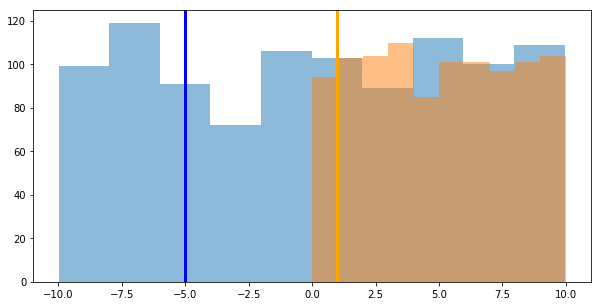

In [21]:
# visualize the prior parameter space
plt.figure(figsize=[10,5])
plt.hist(params[:,0], alpha = 0.5)
plt.hist(params[:,1], alpha = 0.5)
plt.axvline(theta_1_true, color="blue", lw=3)
plt.axvline(theta_2_true, color="orange", lw=3)

pass

## 2. Construct the summarized reference table

In [7]:
p = pd.read_csv("../R/data.csv")
t = pd.read_csv("../R/theta.csv")

In [9]:
p.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101
0,1,1.4,1.622023,2.125251,2.834493,3.743834,4.913503,6.352681,8.022813,9.797231,...,29.980362,30.004168,29.979682,29.932645,29.952753,30.003140,30.031454,30.067504,30.102368,30.066129
1,2,1.4,1.691494,2.367186,3.385963,4.796119,6.569961,8.684840,11.003320,13.413085,...,31.757496,31.777688,31.792898,31.777388,31.777634,31.735566,31.757720,31.789320,31.808671,31.827181
2,3,1.4,1.721952,2.566455,3.885666,5.658425,7.876747,10.569597,13.411479,16.219736,...,33.026387,33.026254,33.046485,33.044599,33.049643,33.045759,33.032649,33.021027,33.047924,33.086730
3,4,1.4,1.807482,2.781983,4.347240,6.475347,9.173246,12.134982,15.229154,18.229889,...,34.037609,34.031354,34.035101,34.033501,34.033429,34.045121,34.017357,34.009949,34.007040,34.015539
4,5,1.4,1.884615,3.111374,5.053171,7.692847,10.827753,14.187040,17.458786,20.423543,...,34.714675,34.722825,34.757303,34.747565,34.721926,34.711760,34.733797,34.768976,34.768394,34.770300


In [1]:
import pandas as pd
from tsfresh import extract_features
from tsfresh.feature_extraction.settings import EfficientFCParameters, MinimalFCParameters


In [92]:
regen = False
mini = True
if mini:
    default_fc_parameters = MinimalFCParameters()
else:
    default_fc_parameters = EfficientFCParameters()
if regen:
    y_pd = pd.DataFrame({"id":index, "time":time, "y":y_data})
    y_data_ss = extract_features(y_pd, column_id="id", column_sort="time",
                                 default_fc_parameters=default_fc_parameters)
    y_data_ss.to_csv("../data/y_data.csv", index=False)
    
    params_pd = pd.DataFrame(params)
    params_pd.columns = ["theta_1", "theta_2"]
    params_pd.to_csv("../data/params.csv", index=False)
else:
    y_data_ss = pd.read_csv("../data/y_data.csv")
    params_pd = pd.read_csv("../data/params.csv")

## 3. Split data


In [93]:
from sklearn.model_selection import train_test_split

# clean the features!
import tsfresh.transformers.per_column_imputer as PCI
pci_trans = PCI.PerColumnImputer()
y_data_ss_pci = pci_trans.fit_transform(y_data_ss)

In [94]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(y_data_ss_pci, params_pd.iloc[:,0], test_size=0.3, random_state=0)
# maybe this row is unneccesary. But still used for clarification
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(y_data_ss_pci, params_pd.iloc[:,1], test_size=0.3, random_state=0)

## 4. Fit data, RF

In [32]:
from sklearn.ensemble import RandomForestRegressor

In [95]:
# a) construct model
# b) fit model
# c) predict with model

model_1 = RandomForestRegressor(random_state=0, n_estimators=10)
model_1.fit(X_train_1,y_train_1)
theta_hat_1 = model_1.predict(X_test_1)

model_2 = RandomForestRegressor(random_state=0, n_estimators=10)
model_2.fit(X_train_2,y_train_2)
theta_hat_2 = model_2.predict(X_test_2)


In [96]:
## scoring
m1score = model_1.score(X_test_1, y_test_1)
m2score = model_2.score(X_test_2, y_test_2)

print("m1 score:", m1score)
print("m2 score:", m2score)

m1 score: 0.9140162698127028
m2 score: 0.8222630527309553


In [97]:
b

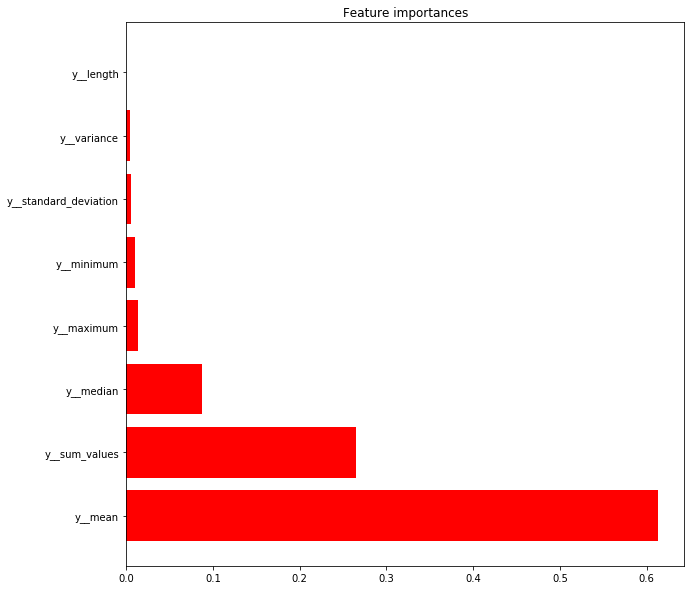

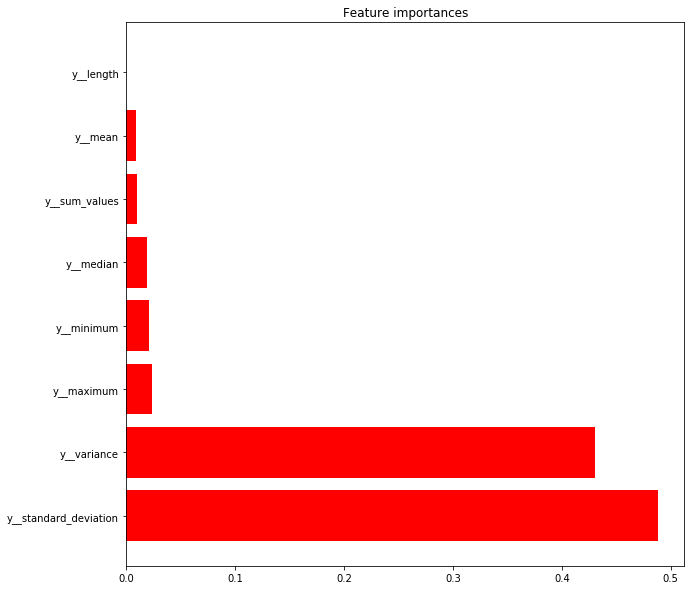

In [98]:
plotFI(10,y_data_ss.columns, model_1)
plotFI(10,y_data_ss.columns, model_2)

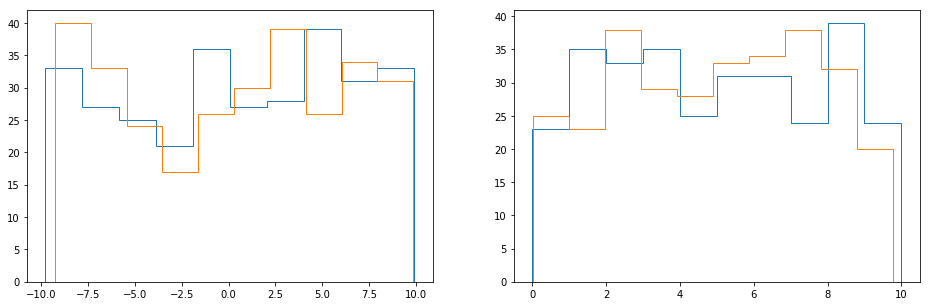

In [99]:
plt.figure(figsize=[16,5])
plt.subplot(1,2,1)
plt.hist(y_test_1, density=False, histtype="step")
plt.hist(theta_hat_1, density=False, histtype="step")

plt.subplot(1,2,2)
plt.hist(y_test_2, density=False, histtype="step")
plt.hist(theta_hat_2, density=False, histtype="step")
pass

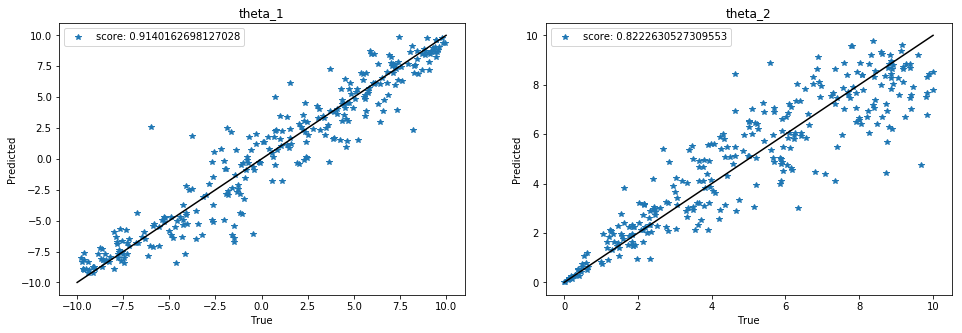

In [100]:
plt.figure(figsize=[16,5])
plt.subplot(1,2,1)
plt.plot(y_test_1, theta_hat_1, '*')
plt.plot([-10,10],[-10,10],'k-')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("theta_1")
plt.legend(["score: " + str(m1score)])

plt.subplot(1,2,2)
plt.plot(y_test_2, theta_hat_2, '*')
plt.plot([0,10],[0,10],'k-')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("theta_2")
plt.legend(["score: " + str(m2score)])



pass

## Using Gradient boosted trees?

In [53]:
from catboost import CatBoostRegressor

In [102]:
model_cat_1 = CatBoostRegressor(n_estimators=100, random_state=0, logging_level="Silent")
model_cat_1.fit(X_train_1, y_train_1)
theta_1_cat = model_cat_1.predict(X_test_1)
m1score_cat = model_cat_1.score(X_test_1,y_test_1)

model_cat_2 = CatBoostRegressor(n_estimators=100, random_state=0, logging_level="Silent")
model_cat_2.fit(X_train_2, y_train_2)
theta_2_cat = model_cat_2.predict(X_test_2)
m2score_cat = model_cat_2.score(X_test_2,y_test_2)



give same plot as above, but now including the catboost


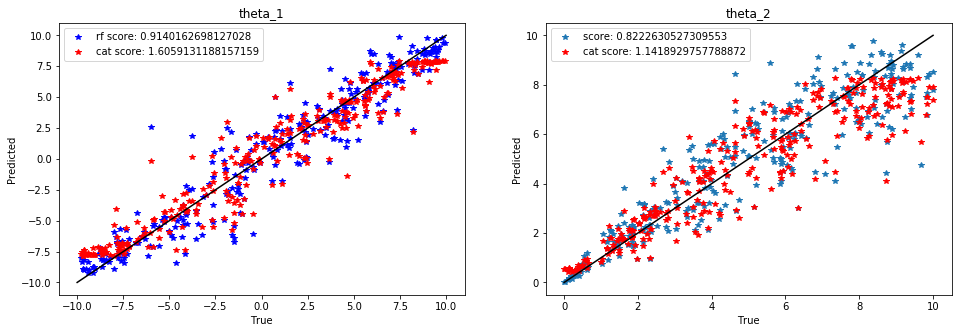

In [103]:
plt.figure(figsize=[16,5])
plt.subplot(1,2,1)
plt.plot(y_test_1, theta_hat_1, 'b*')
plt.plot(y_test_1, theta_1_cat, 'r*')
plt.plot([-10,10],[-10,10],'k-')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("theta_1")
plt.legend(["rf score: " + str(m1score), "cat score: " + str(m1score_cat)])

plt.subplot(1,2,2)
plt.plot(y_test_2, theta_hat_2, '*')
plt.plot(y_test_2, theta_2_cat, 'r*')
plt.plot([0,10],[0,10],'k-')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("theta_2")
plt.legend(["score: " + str(m2score),  "cat score: " + str(m2score_cat)])



pass

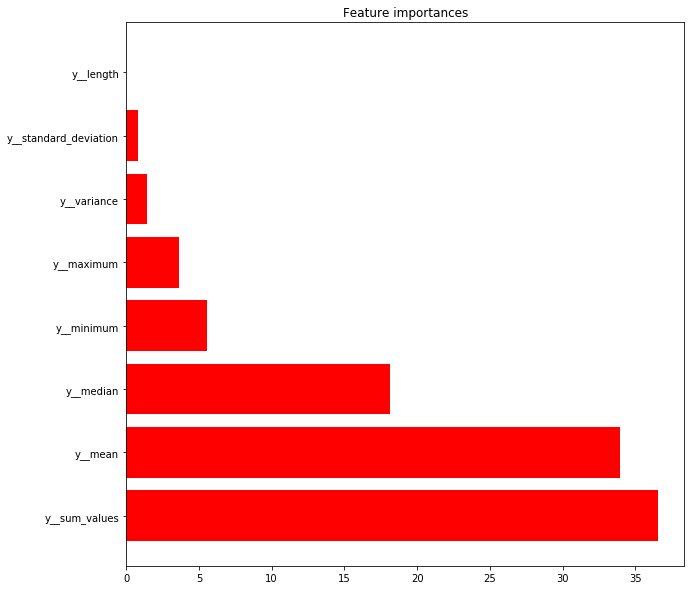

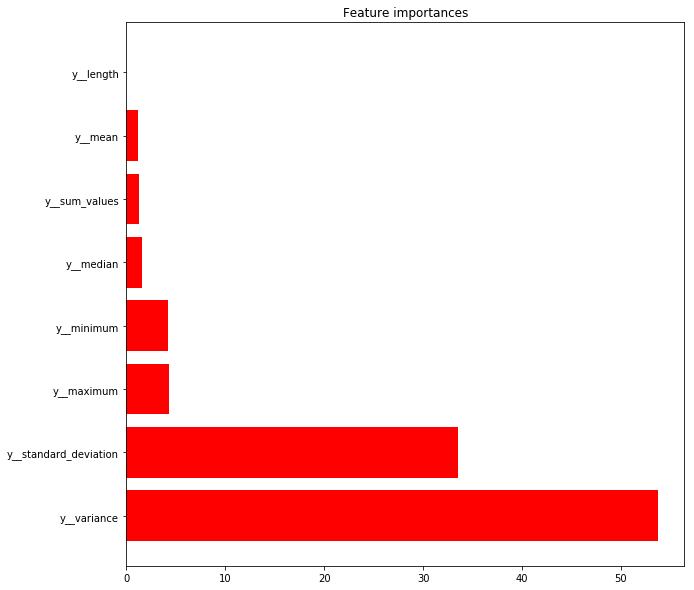

In [105]:
plotFI(10,y_data_ss.columns, model_cat_1)
plotFI(10,y_data_ss.columns, model_cat_2)

## Can we infe the parameters on the observation?

In [107]:
obs_pd = pd.DataFrame({"id":np.repeat(0,size_y), "time":range(size_y), "y":y_obs})
obs_ss = extract_features(obs_pd, column_id="id", column_sort="time",
                          default_fc_parameters = default_fc_parameters)
obs_ss_pci = pci_trans.transform(obs_ss)

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00, 1201.81it/s]


In [109]:
post1 = model_1.predict(obs_ss_pci)
post2 = model_2.predict(obs_ss_pci)

print("True:", [theta_1_true, theta_2_true])
print("Mean posterior:", [post1[0], post2[0]])

True: [-5, 1]
Mean posterior: [-5.356677406432835, 1.0582642620377565]


# Approximate the posterior!

Take a look @
https://scikit-garden.github.io/examples/QuantileRegressionForests/#example

Quantile Regression forests seems to be the way to go. It extends the implemenations in sklearn (I think)


In [110]:
from skgarden import forest, quantile

model_3 = quantile.ExtraTreesQuantileRegressor(random_state=0, 
                                               n_estimators=10)
model_3.fit(X_train_1,y_train_1)
theta_hat_3 = model_3.predict(X_test_1)


 
 with the quantile forest we can not only extract the posterior mean, but also the quantiles!
 

In [111]:
post3 = model_3.predict(obs_ss_pci)
post3_025 = model_3.predict(obs_ss_pci, quantile = 2.5)
post3_975 = model_3.predict(obs_ss_pci, quantile= 97.5)

print("true: ", theta_1_true)
print("mean posterior:", post3[0], "", [post3_025[0], post3_975[0]], "")

true:  -5
mean posterior: -4.47464426924761  [-5.168859004974365, -3.036027431488037] 


In [183]:
model_3.

array([-4.47464427])

In [112]:
X_train_1.shape

(700, 8)

In [113]:
w = model_3.y_weights_

In [114]:
w.shape

(10, 700)


We have B (=10) trees, and N (=700) observations. 

Want weight per feature. Take mean per row


In [115]:
w_feature = w.mean(axis=0)
# normalize
w_feature /= np.sum(w_feature)

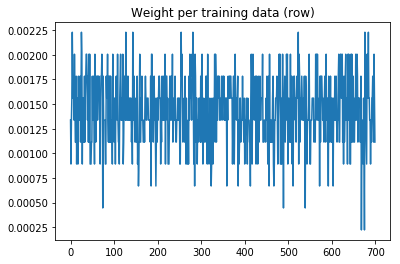

In [117]:
plt.plot(w_feature)
plt.title("Weight per training data (row)")
pass


The weights $w_t(\eta(y))$ provide an approximation of the posterior cumulative distrubtion function (cdf) of $\tau$ given $\eta(y)$ as
$$
\tilde{F}(\tau | \eta(y) ) = \sum_{t=1}^N w_t(\eta(y)) \mathbf{1} \{\tau^{(t)} < \tau \}),
$$
where $\eta(y)$ is the summary statistics of $y$, $\tau$ is the projection $h(\theta)$ that we try to estimate with the regression, $N$ is the numer of datapoints in the training set, and $\mathbf{1}$ denotes the indicator function.

In programmable terms this means:




for a given summary of an observation,
sum the product of weights times 




In [158]:
range(len(w_feature))b

range(0, 700)

In [175]:
np.array(y_train_1)[0]

1.7631534098234347

In [177]:
j = 2
i = 2
w_feature[j]*np.int64(np.array(y_train_1)[j] < tau_vec_1[0])

0.0

In [179]:
eta = obs_ss_pci
tau_vec_1 = np.linspace(-10,10,100)
F_tilde = np.zeros(len(tau_vec_1))

for i in range(len(tau_vec_1)):
    F_tilde[i] = 0
    ## for every datapoint in training
    for j in range(len(w_feature)):
        F_tilde[i] += w_feature[j] * np.int64(np.array(y_train_1)[j] < tau_vec_1[i])

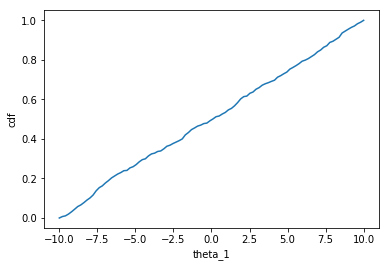

In [180]:
plt.plot(tau_vec_1, F_tilde)
plt.xlabel("theta_1")
plt.ylabel("cdf")
pass

In [181]:
# by numerically differentiating the cdf once
# we can retrieve the approximated pdf.
def cdf2pdf(F,x):
    P = np.zeros(len(F))
    for i in range(1,len(F)):
        P[i-1] = (F[i] - F[i-1]) / (x[i] - x[i-1])
    return(P)

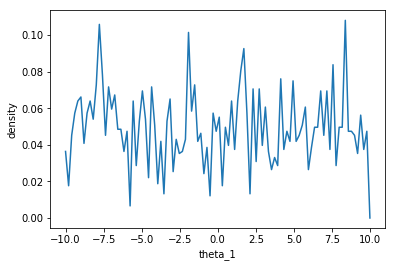

In [182]:
p = cdf2pdf(F_tilde,tau_vec_1)

## plot the posterior
plt.plot(tau_vec_1, p)
plt.xlabel("theta_1")
plt.ylabel("density")
pass